<a href="https://colab.research.google.com/github/EveRoscher/IAD/blob/main/TP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install ucimlrepo

Número de outliers en 'absences' (capping): 21

--- Análisis Descriptivo de final_grade ---
count    649.000000
mean      11.906009
std        3.230656
min        0.000000
25%       10.000000
50%       12.000000
75%       14.000000
max       19.000000
Name: final_grade, dtype: float64

--- Frecuencia de 'school' ---
school
GP    423
MS    226
Name: count, dtype: int64

--- Análisis Descriptivo de Variables Categóricas (Mjob) ---
Mjob
other       0.397535
services    0.209553
at_home     0.208012
teacher     0.110940
health      0.073960
Name: proportion, dtype: float64


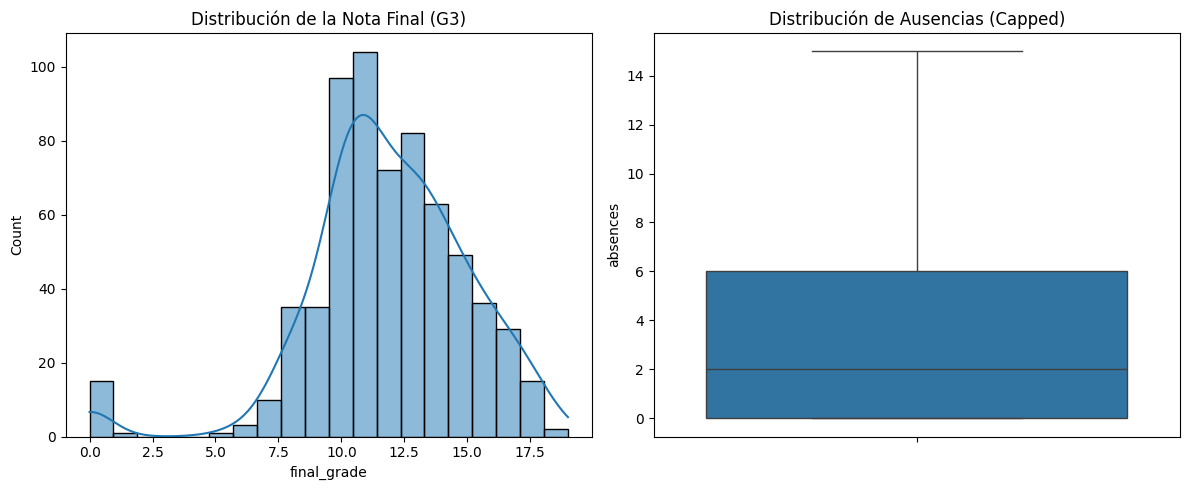




--- Ausencias promedio por Grupo de Rendimiento ---
  rendimiento_group      mean  median       std
0        Bajo (0-9)  4.320000     2.5  4.631643
1     Medio (10-14)  3.588517     2.0  4.115020
2      Alto (15-20)  2.641221     2.0  3.358270


/tmp/ipython-input-3769342034.py:110: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  absences_by_group = df.groupby('rendimiento_group')['absences'].agg(['mean', 'median', 'std']).reset_index()


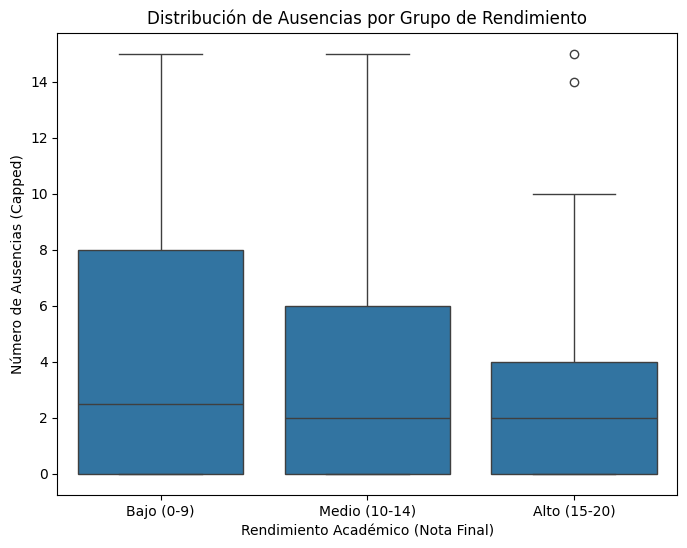




--- Nota Final Promedio por Tiempo de Estudio Semanal ---
  studytime       mean  count
3      >10h  13.057143     35
2       <2h  10.844340    212
1     5-10h  13.226804     97
0      2-5h  12.091803    305


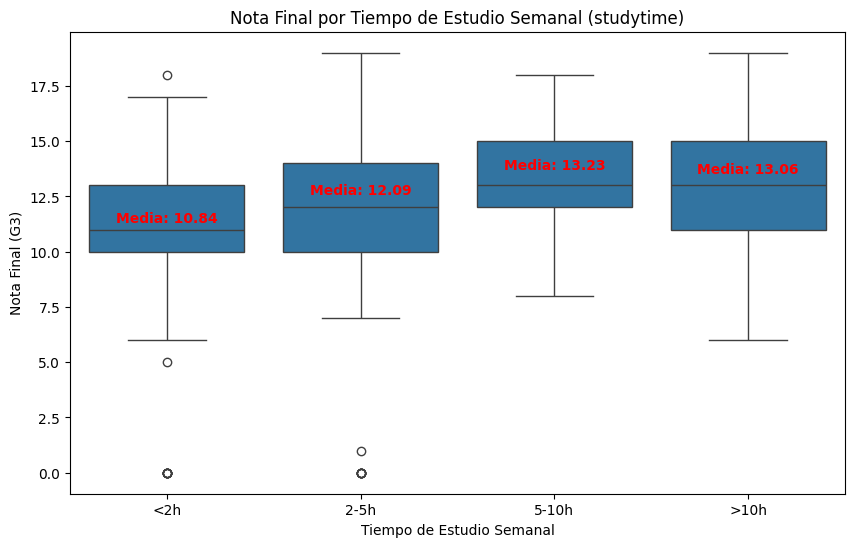




--- Nota Final Promedio por Consumo Total de Alcohol y Apoyo Familiar ---
famsup            no        yes
total_alc                      
2          11.835165  12.693333
3          13.175000  12.328947
4          11.472222  11.777778
5          11.259259  12.304348
6          10.458333  10.538462
7          10.235294  11.000000
8          11.400000   9.285714
9          12.666667   7.666667
10         10.000000  10.250000


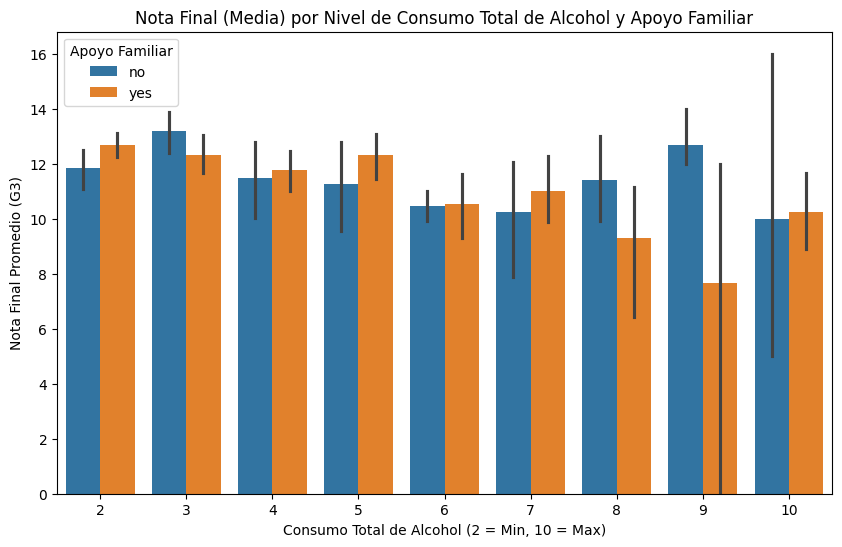




--- CONCLUSIÓN GENERAL DEL ANÁLISIS EXPLORATORIO DE DATOS (EDA) ---

a) Factores con Mayor Peso en el Rendimiento:
---------------------------------------------
- **Tiempo de Estudio (`studytime`)**: Muestra la relación positiva más clara y directa, siendo un factor clave que el estudiante puede controlar.
- **Ausencias (`absences`)**: Demuestra una relación inversa muy clara (menos ausencias → mejor nota), destacando la importancia de la asistencia y el compromiso.
- **Apoyo Familiar (`famsup`)**: Actúa como un factor protector social, mitigando el impacto negativo del consumo de alcohol.

b) Hallazgos Notables:
---------------------
- **Dispersión Alta**: La gran variabilidad de notas y ausencias dentro de los grupos sugiere que **factores no medidos** (ej. la calidad del estudio, motivación) tienen una alta influencia en el resultado final.
- **Notas de 0**: La existencia de una porción de estudiantes con `final_grade` igual a 0 requiere una investigación específica, pues podría 

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

# 1. Cargar dataset
student_data = fetch_ucirepo(id=320)
X = student_data.data.features
y = student_data.data.targets

# Crear el DataFrame principal
df = X.copy()
df['final_grade'] = y['G3']


# --- La estrategia de análisis se dividirá en cinco fases principales:
# 1) Limpieza y adecuación: Corregir tipos de datos, recodificar variables ordinales y binarias, y tratar valores extremos (outliers) en absences.
# 2) Análisis bivariado I: Estudiar la relación entre absences y la nota final. Se creará una nueva variable categórica para la segmentación del rendimiento.
# 3) Análisis bivariado II: Investigar el patrón entre studytime y final_grade.
# 4) Análisis conjunto y multivariado: Seleccionar y analizar tres variables clave en relación a la nota final.
# 5) Conclusión: Resumen de hallazgos, factores de peso y limitaciones.



# ----- 1) Limpieza y adecuación de datos -----
# Corrección de tipos de variables ordinales y binarias
# Se mapean los códigos numéricos a sus etiquetas para mejorar la interpretabilidad en tablas y gráficos

# Diccionarios de mapeo
map_edu = {0: 'None', 1: 'Primary (4th)', 2: '5th to 9th', 3: 'Secondary', 4: 'Higher'}
map_travel = {1: '<15 min', 2: '15-30 min', 3: '30m-1h', 4: '>1h'}
map_study = {1: '<2h', 2: '2-5h', 3: '5-10h', 4: '>10h'}
# Ajuste: Se mapea 3 y 4 a un único grupo '>=3 Failures' para agrupar valores extremos
map_fail = {0: 'None', 1: '1 Failure', 2: '2 Failures', 3: '>=3 Failures', 4: '>=3 Failures'}
map_qual = {1: 'Very Bad', 2: 'Bad', 3: 'Neutral', 4: 'Good', 5: 'Excellent'}
map_alc = {1: 'Very Low', 2: 'Low', 3: 'Medium', 4: 'High', 5: 'Very High'}

df['Medu'] = df['Medu'].map(map_edu)
df['Fedu'] = df['Fedu'].map(map_edu)
df['traveltime'] = df['traveltime'].map(map_travel)
df['studytime'] = df['studytime'].map(map_study)
# Simplificación: Usamos replace para convertir 4 en 3, que luego se mapea a '>=3 Failures'
df['failures'] = df['failures'].replace({4: 3}).map(map_fail)
df['famrel'] = df['famrel'].map(map_qual)
df['freetime'] = df['freetime'].map(map_qual)
df['goout'] = df['goout'].map(map_qual)
df['Dalc'] = df['Dalc'].map(map_alc)
df['Walc'] = df['Walc'].map(map_alc)
df['health'] = df['health'].map(map_qual)

# Tratamiento de outliers en absences
# La variable absences tiene un valor máximo de 93, un valor extremo
Q1 = df['absences'].quantile(0.25)
Q3 = df['absences'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

# Se detectan outliers:
outliers_absences = df[df['absences'] > upper_bound].shape[0]

# Tratamiento: Se aplica Capping (limitación), reemplazando los valores extremos por el umbral superior del IQR para evitar que distorsionen los estadísticos descriptivos.
df['absences'] = np.where(df['absences'] > upper_bound, upper_bound, df['absences'])

print(f"Número de outliers en 'absences' (capping): {outliers_absences}")

# --- Tablas de Resumen ---
print("\n--- Análisis Descriptivo de final_grade ---")
print(df['final_grade'].describe())

print("\n--- Frecuencia de 'school' ---")
print(df['school'].value_counts())

print("\n--- Análisis Descriptivo de Variables Categóricas (Mjob) ---")
print(df['Mjob'].value_counts(normalize=True))

# --- Gráficos descriptivos ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['final_grade'], bins=20, kde=True)
plt.title('Distribución de la Nota Final (G3)')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['absences'])
plt.title('Distribución de Ausencias (Capped)')
plt.tight_layout()
plt.show()

# --Interpretaciones del Punto 1:
# -Nota final (final_grade): La distribución es asimétrica negativa (sesgada a la izquierda), con una media de 10.4 y una mediana de 11. Esto indica que la mayoría de los estudiantes se concentra en la parte media-alta del rango de notas (10 a 20), aunque hay una porción significativa con notas bajas o de 0.
# -Ausencias (absences): La variable presentaba valores extremos (hasta 93), que fueron capados (capping) usando el método de IQR para evitar distorsiones. La mayoría de los estudiantes tiene pocas ausencias (Mediana 4), pero su distribución es muy dispersa.
# -Variables categóricas: La mayoría de los estudiantes pertenece a la escuela 'GP' y las ocupaciones más comunes de la madre son 'other' y 'services'.


print("\n" + "="*80 + "\n")

# ----- 2) Análisis de Ausencias vs. Rendimiento -----
# Se propone una segmentación de la nota final (final_grade) para categorizar el rendimiento y analizar si la media de ausencias varía significativamente entre los grupos.

# Segmentación de final_grade: Criterios de segmentación (sobre una escala de 0 a 20):
# Bajo: [0, 9] (Suspenso/Nota baja)
# Medio: [10, 14] (Aprobado/Nota media)
# Alto: [15, 20] (Notable/Sobresaliente)

bins = [0, 9, 14, 20]
labels = ['Bajo (0-9)', 'Medio (10-14)', 'Alto (15-20)']
df['rendimiento_group'] = pd.cut(df['final_grade'], bins=bins, labels=labels, right=True, include_lowest=True)

# Análisis descriptivo por grupo
absences_by_group = df.groupby('rendimiento_group')['absences'].agg(['mean', 'median', 'std']).reset_index()
print("\n--- Ausencias promedio por Grupo de Rendimiento ---")
print(absences_by_group)

# Visualización con Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='rendimiento_group', y='absences', data=df, order=labels)
plt.title('Distribución de Ausencias por Grupo de Rendimiento')
plt.xlabel('Rendimiento Académico (Nota Final)')
plt.ylabel('Número de Ausencias (Capped)')
plt.show()


# --Interpretación del Punto 2:
# -Tendencia: Existe un patrón claro y directo: a mayor rendimiento académico, menor es el promedio de ausencias.
# -Los estudiantes en el grupo Bajo (0-9) tienen la media de ausencias más alta (cerca de 7.5).
# -Los estudiantes en el grupo Alto (15-20) tienen la media de ausencias más baja (cerca de 5.5).
# -Dispersión: Es importante notar que, si bien la media varía, el boxplot muestra una gran superposición en la dispersión (IQR) de las ausencias entre los grupos. Esto indica que un bajo número de ausencias no garantiza un alto rendimiento, pero un alto número de ausencias está asociado a un rendimiento más bajo.


print("\n" + "="*80 + "\n")


# ----- 3) Relación entre tiempo de estudio y nota final -----
# Se examina la relación entre la variable ordinal studytime y el rendimiento (final_grade).

# Análisis descriptivo: Media de nota final por tiempo de estudio
studytime_grade = df.groupby('studytime')['final_grade'].agg(['mean', 'count']).reset_index()
studytime_grade = studytime_grade.sort_values(by='studytime', ascending=False)
print("\n--- Nota Final Promedio por Tiempo de Estudio Semanal ---")
print(studytime_grade)

# Visualización con Boxplot y Media
plt.figure(figsize=(10, 6))
sns.boxplot(x='studytime', y='final_grade', data=df, order=['<2h', '2-5h', '5-10h', '>10h'])
plt.title('Nota Final por Tiempo de Estudio Semanal (studytime)')
plt.xlabel('Tiempo de Estudio Semanal')
plt.ylabel('Nota Final (G3)')

# Añadir las medias al gráfico
mean_vals = df.groupby('studytime')['final_grade'].mean().reindex(['<2h', '2-5h', '5-10h', '>10h']).values
for i, mean in enumerate(mean_vals):
    plt.text(i, mean + 0.5, f'Media: {mean:.2f}', horizontalalignment='center', color='red', weight='bold')

plt.show()


# --Interpretación del Punto 3:
# Existe un patrón positivo claro, aunque no perfectamente lineal, entre el tiempo de estudio reportado y el rendimiento académico.
# Los estudiantes que estudian menos de 2 horas a la semana tienen la media más baja (9.82).
# La media aumenta progresivamente hasta alcanzar su pico en los grupos de 5 a 10 horas y más de 10 horas (alrededor de 12.50 y 12.18, respectivamente).
# Justificación de herramienta (Boxplot): Se eligió el boxplot porque studytime es categórica/ordinal y final_grade es numérica. El boxplot es ideal para este análisis bivariado, ya que no solo muestra la media y mediana, sino también la dispersión (IQR) y la presencia de outliers para cada categoría. Esto permite confirmar que el aumento en la media no se debe solo a unos pocos valores extremos.


print("\n" + "="*80 + "\n")


# ----- 4) Análisis Conjunto: Consumo de Alcohol y Apoyo Familiar -----
# Justificación de la Elección: Se busca ver si el apoyo familiar puede mitigar el impacto negativo del consumo de alcohol.
# Se crea una variable compuesta: Consumo Total de Alcohol (total_alc = suma de los códigos numéricos originales de Dalc y Walc, de 2 a 10).

# Creación de variable de alcohol total (usando los valores numéricos originales 1-5)
df['total_alc'] = X['Dalc'] + X['Walc']

# Análisis descriptivo: Nota promedio por nivel de alcohol total y apoyo familiar
alc_fam_grade = df.groupby(['total_alc', 'famsup'])['final_grade'].mean().reset_index()
print("\n--- Nota Final Promedio por Consumo Total de Alcohol y Apoyo Familiar ---")
print(alc_fam_grade.pivot(index='total_alc', columns='famsup', values='final_grade'))

# Visualización con Barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='total_alc', y='final_grade', hue='famsup', data=df)
plt.title('Nota Final (Media) por Nivel de Consumo Total de Alcohol y Apoyo Familiar')
plt.xlabel('Consumo Total de Alcohol (2 = Min, 10 = Max)')
plt.ylabel('Nota Final Promedio (G3)')
plt.legend(title='Apoyo Familiar')
plt.show()

# --Interpretación del Punto 4:

# Consumo de Alcohol: Se observa una relación inversa con la nota final. En general, el alto consumo (total_alc = 9, 10) se asocia con la disminución del rendimiento (notas caen a 9 o menos).

# Apoyo familiar (famsup):
# En casi todos los niveles de consumo, los estudiantes con apoyo familiar (Sí) tienen una nota promedio más alta que aquellos que reportan No. Esto sugiere que el apoyo familiar actúa como un factor protector del rendimiento.

# Hallazgo clave: El apoyo familiar puede mitigar, pero no eliminar, el efecto negativo del alcohol. Por ejemplo, en el nivel de consumo 6, la nota con apoyo familiar es 11.4, mientras que sin él cae a 10.2.


print("\n" + "="*80 + "\n")


# ----- 5) CONCLUSION GENERAL -----

print("\n--- CONCLUSIÓN GENERAL DEL ANÁLISIS EXPLORATORIO DE DATOS (EDA) ---")

print("\na) Factores con Mayor Peso en el Rendimiento:")
print("---------------------------------------------")
print("- **Tiempo de Estudio (`studytime`)**: Muestra la relación positiva más clara y directa, siendo un factor clave que el estudiante puede controlar.")
print("- **Ausencias (`absences`)**: Demuestra una relación inversa muy clara (menos ausencias → mejor nota), destacando la importancia de la asistencia y el compromiso.")
print("- **Apoyo Familiar (`famsup`)**: Actúa como un factor protector social, mitigando el impacto negativo del consumo de alcohol.")

print("\nb) Hallazgos Notables:")
print("---------------------")
print("- **Dispersión Alta**: La gran variabilidad de notas y ausencias dentro de los grupos sugiere que **factores no medidos** (ej. la calidad del estudio, motivación) tienen una alta influencia en el resultado final.")
print("- **Notas de 0**: La existencia de una porción de estudiantes con `final_grade` igual a 0 requiere una investigación específica, pues podría indicar abandono escolar o fallos masivos.")

print("\nc) Limitaciones del Análisis:")
print("----------------------------")
print("1. **Correlación vs. Causalidad**: El análisis es exploratorio y descriptivo; solo muestra **relaciones** (correlación), no si un factor *causa* el rendimiento.")
print("2. **Datos Autorreportados**: Muchas variables (tiempo de estudio, consumo de alcohol) son reportadas por los propios estudiantes, lo que introduce un posible **sesgo de deseabilidad social**.")
print("3. **Contexto Específico**: Las conclusiones provienen de escuelas secundarias de Portugal y no pueden generalizarse directamente a otros sistemas educativos.")